In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score

from catboost import CatBoostClassifier, Pool, cv

In [2]:
heart = pd.read_csv("heart.csv")
heart.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
o2_sat = pd.read_csv("o2Saturation.csv")
o2_sat.head()

,98.6
0,98.6
1,98.6
2,98.6
3,98.1
4,97.5


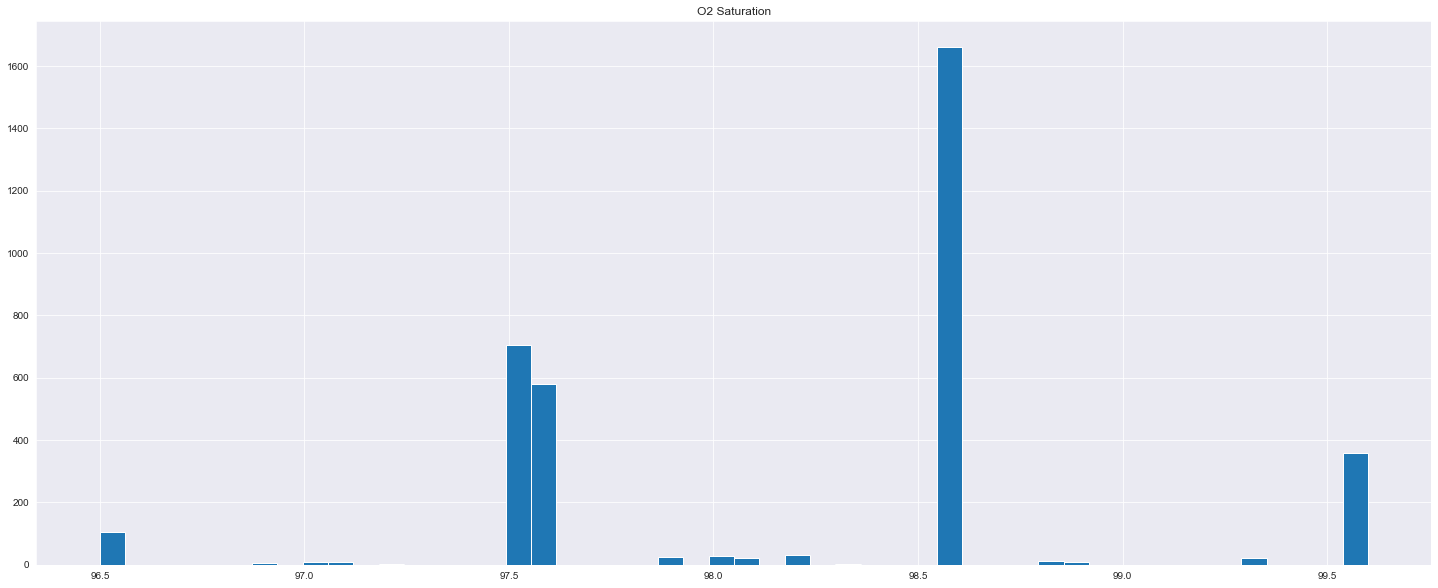

In [4]:
#then they get the distribution of the saturation
plt.figure(figsize = (25,10))
plt.hist(o2_sat, bins = 50)
plt.title("O2 Saturation")
plt.grid(True)
plt.show()

In [5]:
#now we want to drop duplicates
df = heart.drop_duplicates().reset_index(drop = True).copy()

In [6]:
#they don't break it up with x_train, x_test, y_train, y_test they just break it into train and test
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

In [7]:
print("train set size:", len(train_set))
print("test set size:", len(test_set))

train set size: 241
test set size: 61


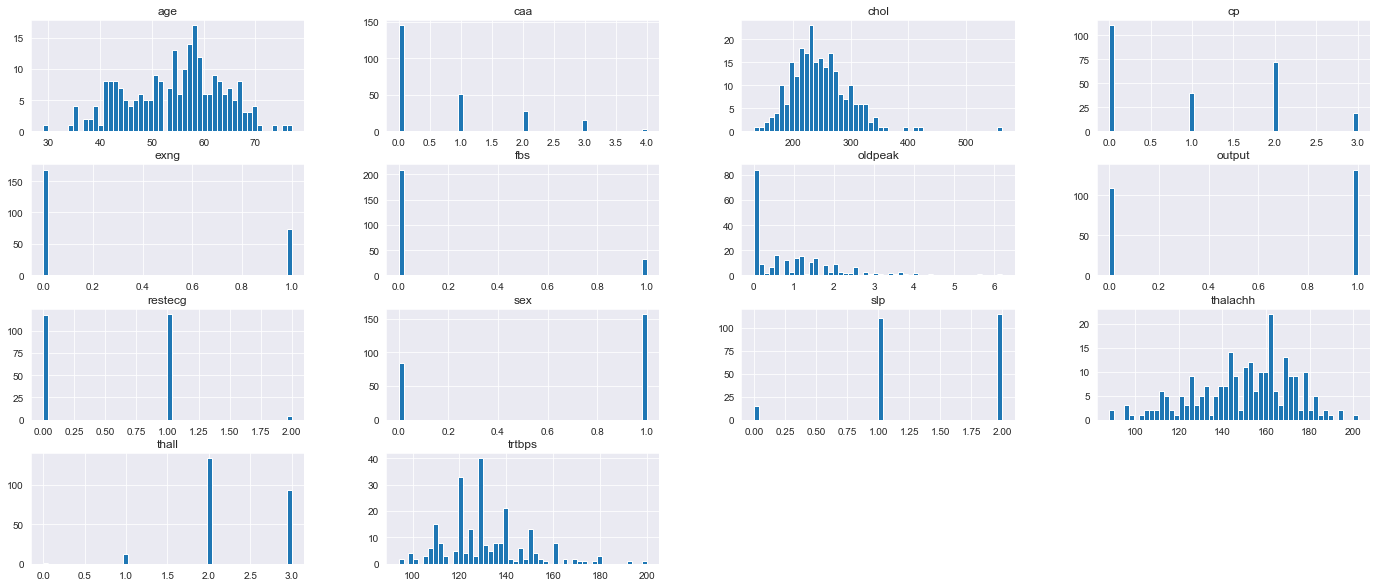

In [8]:
train_set.hist(figsize = (24,10), bins = 50)
plt.show()

<AxesSubplot:>

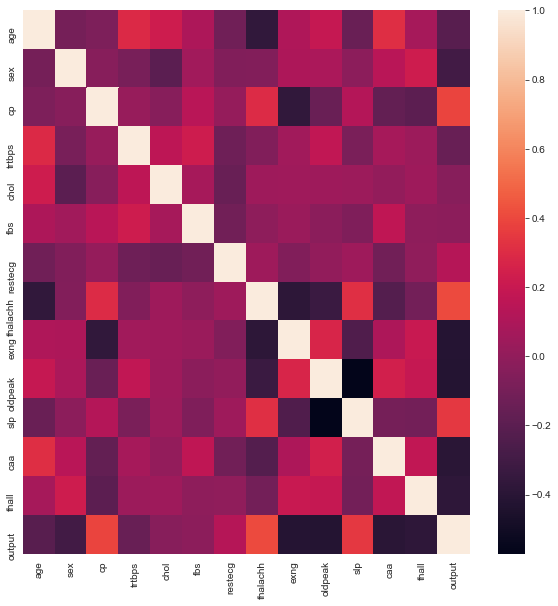

In [9]:
train_set_corr = train_set.corr()
plt.figure(figsize = (10,10))
sns.heatmap(train_set_corr)

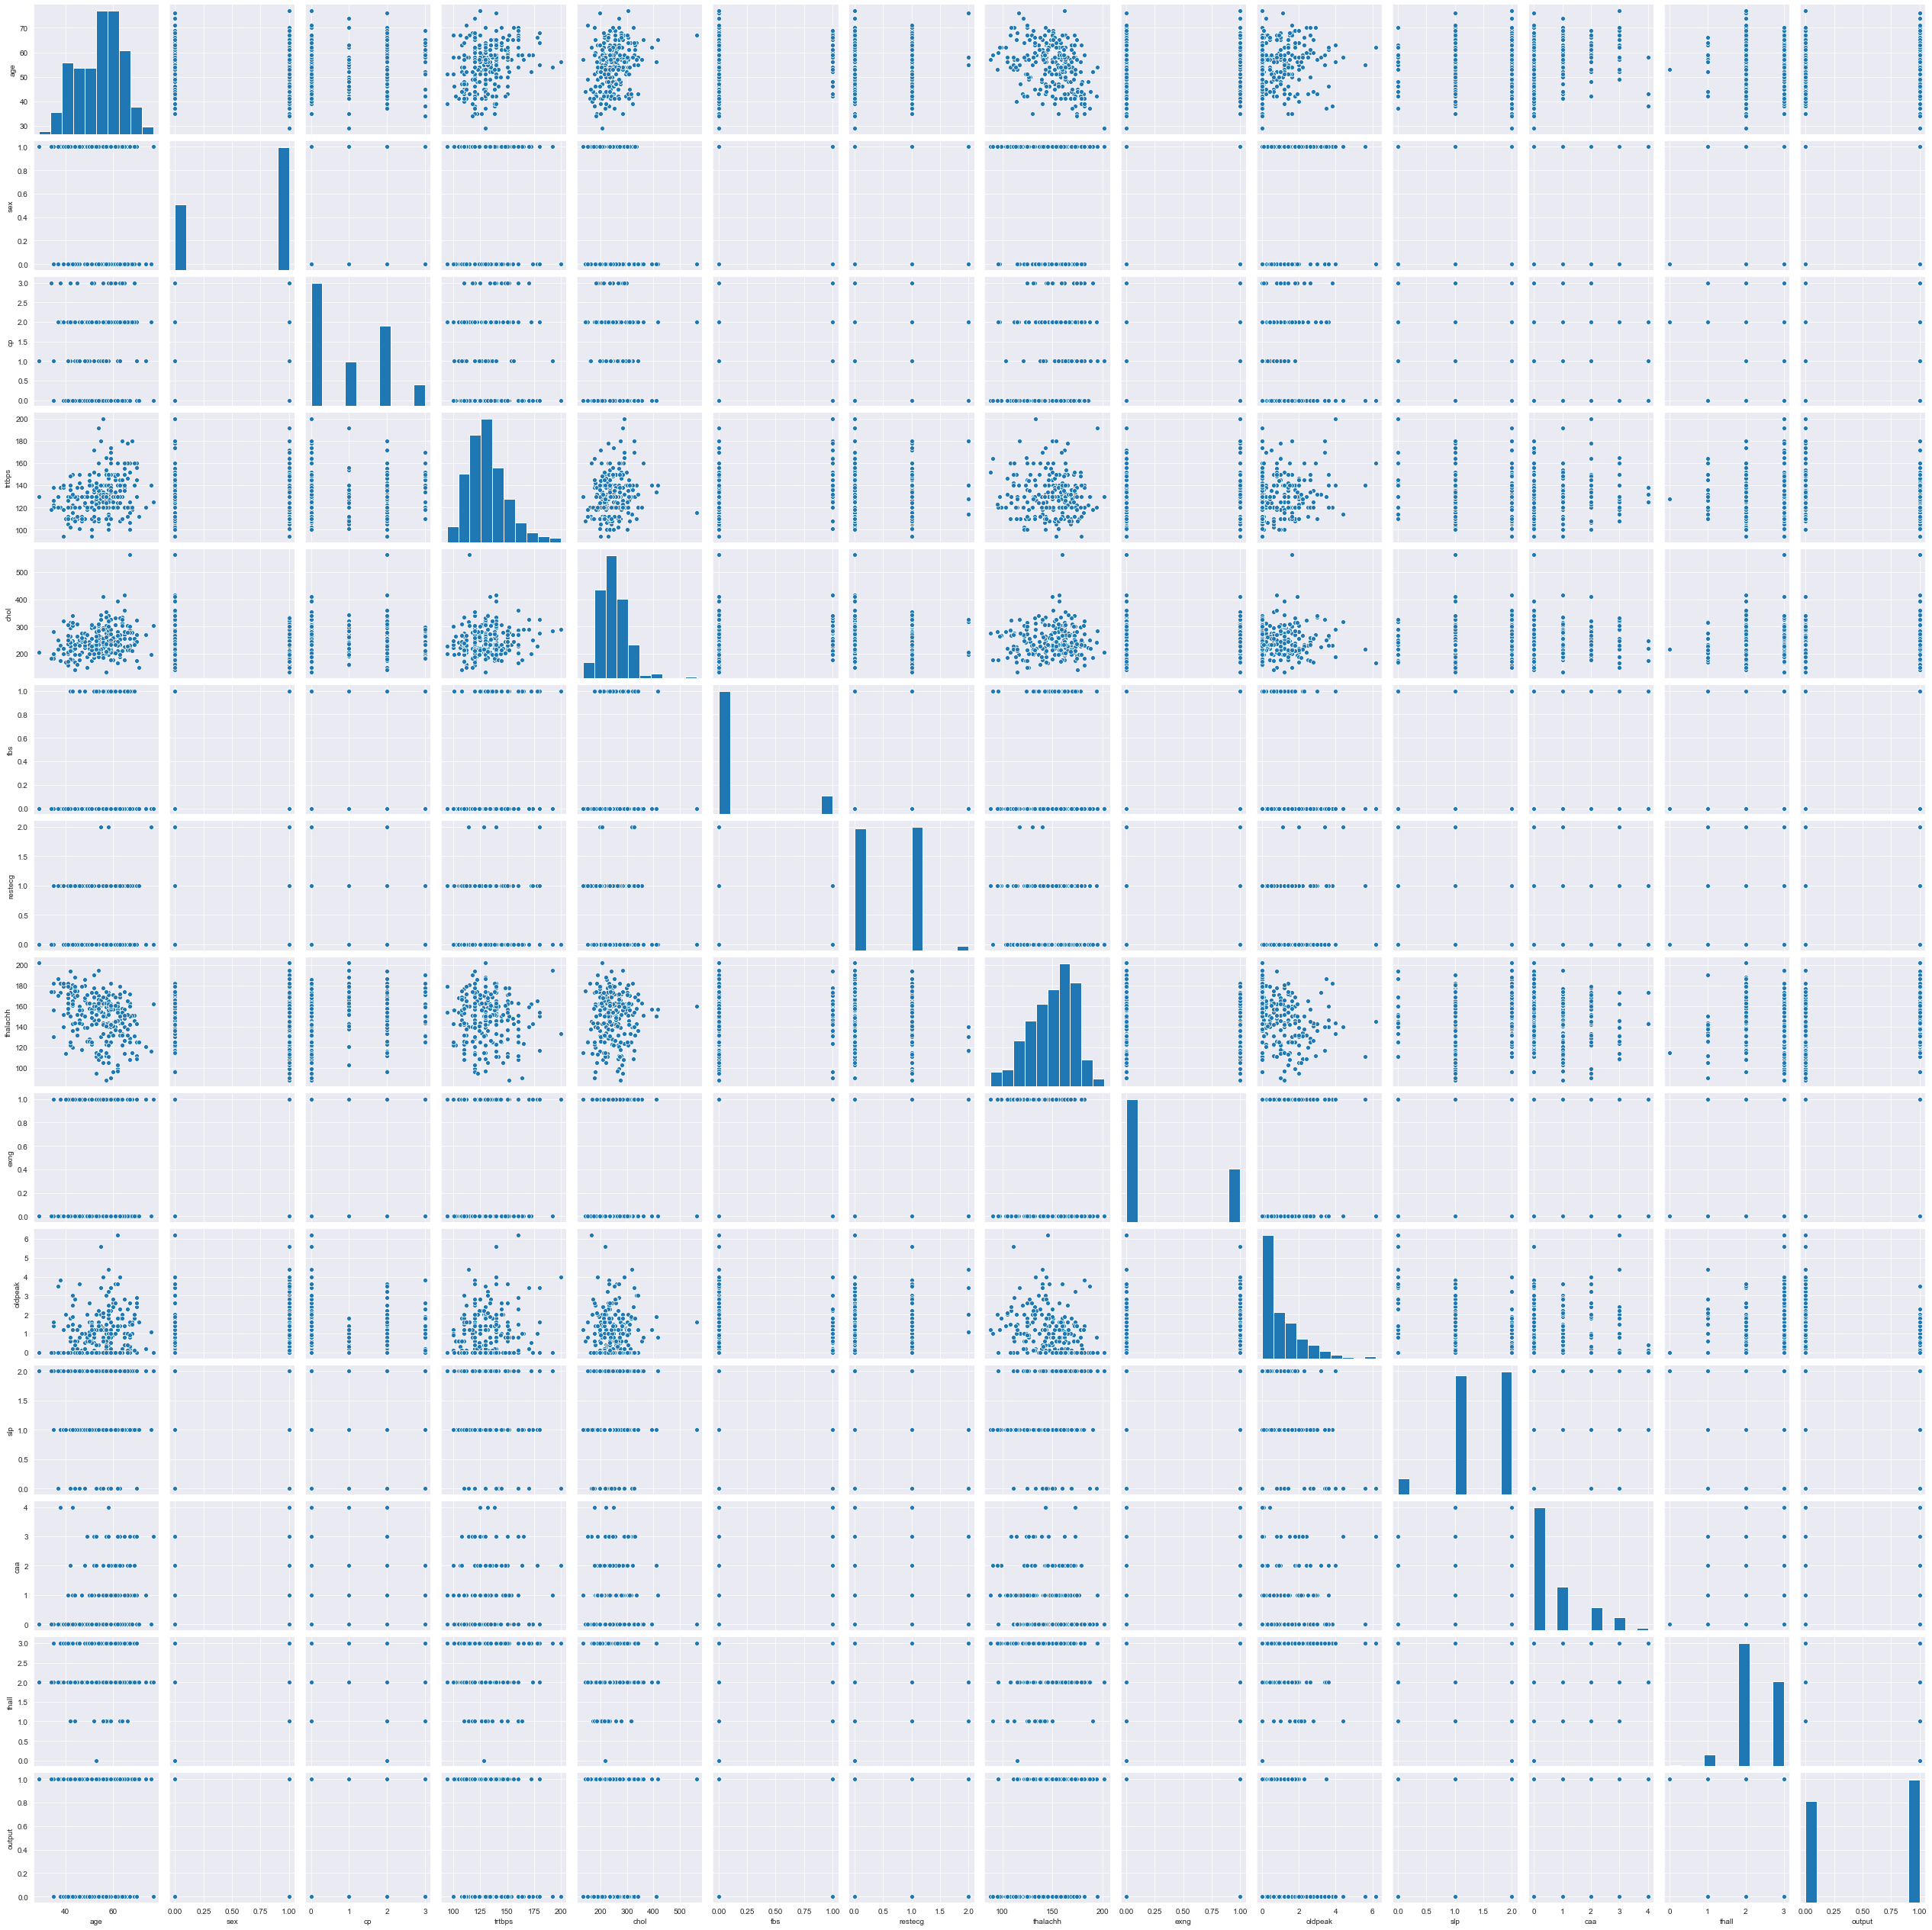

In [10]:
sns.pairplot(train_set)

In [11]:
train_set.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
132,42,1,1,120,295,0,1,162,0,0.0,2,0,2,1
202,68,1,2,180,274,1,0,150,1,1.6,1,0,3,0
196,67,1,0,125,254,1,1,163,0,0.2,1,2,3,0
75,55,0,1,135,250,0,0,161,0,1.4,1,0,2,1
176,64,1,2,140,335,0,1,158,0,0.0,2,0,2,0


In [12]:
#they split the age range into 5 groups
train_set['age_group'] = pd.qcut(train_set['age'], 5)
train_set.head()

<ipython-input-12-cc20e47ae6e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['age_group'] = pd.qcut(train_set['age'], 5)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,age_group
132,42,1,1,120,295,0,1,162,0,0.0,2,0,2,1,"(28.999, 45.0]"
202,68,1,2,180,274,1,0,150,1,1.6,1,0,3,0,"(62.0, 77.0]"
196,67,1,0,125,254,1,1,163,0,0.2,1,2,3,0,"(62.0, 77.0]"
75,55,0,1,135,250,0,0,161,0,1.4,1,0,2,1,"(53.0, 58.0]"
176,64,1,2,140,335,0,1,158,0,0.0,2,0,2,0,"(62.0, 77.0]"


In [13]:
#then they groupby
train_set.groupby('age_group')['output'].agg(['count', 'mean']).sort_values(by = 'mean', ascending = False)

,count,mean
age_group,,
"(28.999, 45.0]",51,0.745098
"(45.0, 53.0]",49,0.653061
"(62.0, 77.0]",48,0.520833
"(53.0, 58.0]",60,0.466667
"(58.0, 62.0]",33,0.272727


In [14]:
#then they groupby the age and sex
train_set.groupby(['age_group', 'sex'])['output'].agg(['count', 'mean'])

count      mean
age_group      sex                 
(28.999, 45.0] 0       16  0.937500
               1       35  0.657143
(45.0, 53.0]   0       14  0.928571
               1       35  0.542857
(53.0, 58.0]   0       21  0.666667
               1       39  0.358974
(58.0, 62.0]   0       12  0.333333
               1       21  0.238095
(62.0, 77.0]   0       21  0.809524
               1       27  0.296296

In [15]:
#then they look at sex
train_set.groupby("sex")['output'].agg(['count', 'mean'])

,count,mean
sex,,
0,84,0.75000
1,157,0.43949


<AxesSubplot:xlabel='trtbps'>

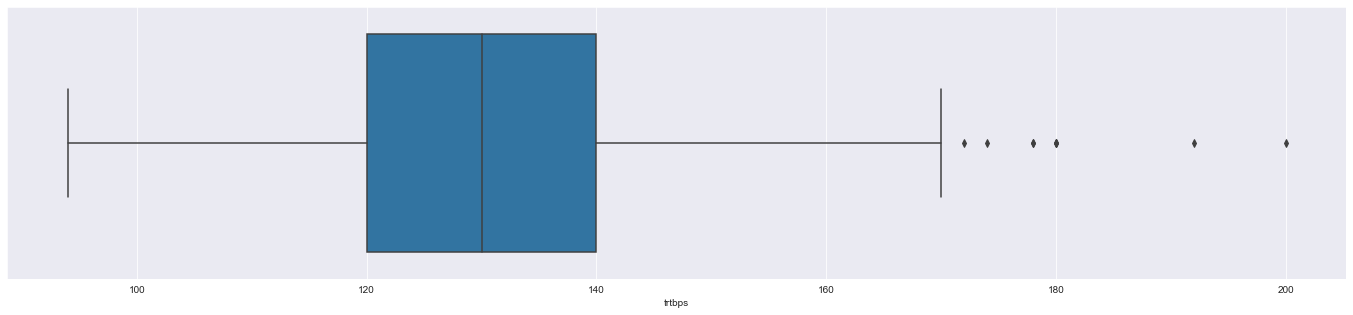

In [16]:
plt.figure(figsize = (24,5))
sns.boxplot(df['trtbps'])

<AxesSubplot:xlabel='chol'>

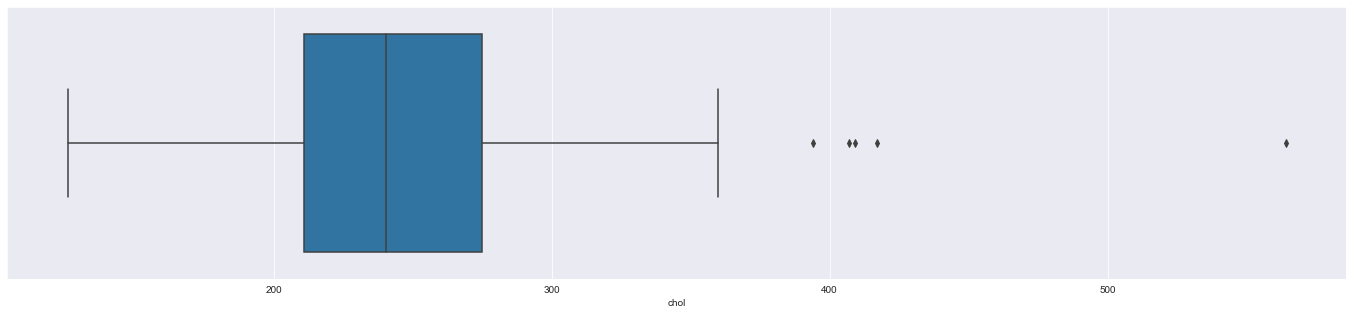

In [17]:
plt.figure(figsize = (24,5))
sns.boxplot(df['chol'])

<AxesSubplot:xlabel='thalachh'>

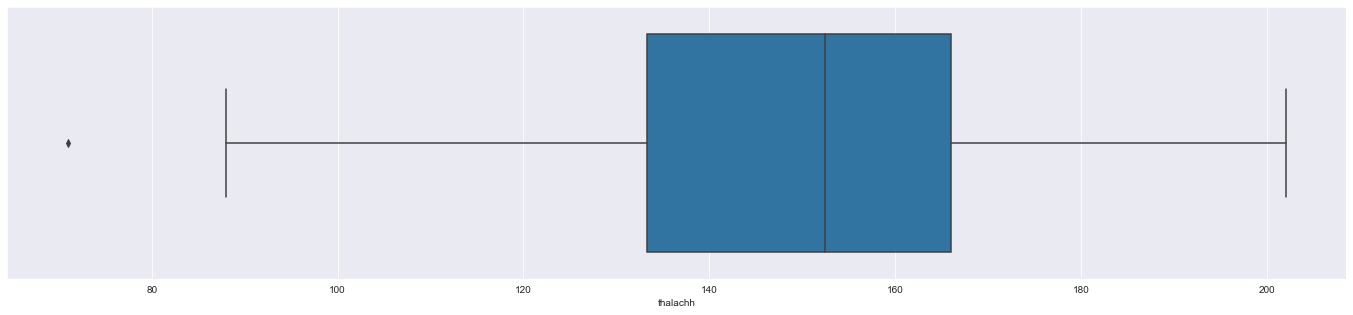

In [18]:
plt.figure(figsize = (24,5))
sns.boxplot(df['thalachh'])

In [20]:
train_set.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,age_group
132,42,1,1,120,295,0,1,162,0,0.0,2,0,2,1,"(28.999, 45.0]"
202,68,1,2,180,274,1,0,150,1,1.6,1,0,3,0,"(62.0, 77.0]"
196,67,1,0,125,254,1,1,163,0,0.2,1,2,3,0,"(62.0, 77.0]"
75,55,0,1,135,250,0,0,161,0,1.4,1,0,2,1,"(53.0, 58.0]"
176,64,1,2,140,335,0,1,158,0,0.0,2,0,2,0,"(62.0, 77.0]"


In [22]:
train_set['trtbps_group'] = pd.qcut(df['trtbps'], 5)
train_set.head()

<ipython-input-22-ec33d75b68df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['trtbps_group'] = pd.qcut(df['trtbps'], 5)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,age_group,trtbps_group
132,42,1,1,120,295,0,1,162,0,0.0,2,0,2,1,"(28.999, 45.0]","(93.999, 120.0]"
202,68,1,2,180,274,1,0,150,1,1.6,1,0,3,0,"(62.0, 77.0]","(144.0, 200.0]"
196,67,1,0,125,254,1,1,163,0,0.2,1,2,3,0,"(62.0, 77.0]","(120.0, 126.0]"
75,55,0,1,135,250,0,0,161,0,1.4,1,0,2,1,"(53.0, 58.0]","(134.0, 144.0]"
176,64,1,2,140,335,0,1,158,0,0.0,2,0,2,0,"(62.0, 77.0]","(134.0, 144.0]"


In [23]:
train_set.groupby("trtbps_group")['output'].agg(['count', 'mean'])

,count,mean
trtbps_group,,
"(93.999, 120.0]",81,0.617284
"(120.0, 126.0]",20,0.350000
"(126.0, 134.0]",52,0.576923
"(134.0, 144.0]",40,0.650000
"(144.0, 200.0]",48,0.395833


In [24]:
#samething for cholsetoral
train_set['chol_group'] = pd.qcut(df['chol'], 5)
train_set.head()

<ipython-input-24-8a9376a94b86>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['chol_group'] = pd.qcut(df['chol'], 5)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,age_group,trtbps_group,chol_group
132,42,1,1,120,295,0,1,162,0,0.0,2,0,2,1,"(28.999, 45.0]","(93.999, 120.0]","(285.6, 564.0]"
202,68,1,2,180,274,1,0,150,1,1.6,1,0,3,0,"(62.0, 77.0]","(144.0, 200.0]","(254.0, 285.6]"
196,67,1,0,125,254,1,1,163,0,0.2,1,2,3,0,"(62.0, 77.0]","(120.0, 126.0]","(230.0, 254.0]"
75,55,0,1,135,250,0,0,161,0,1.4,1,0,2,1,"(53.0, 58.0]","(134.0, 144.0]","(230.0, 254.0]"
176,64,1,2,140,335,0,1,158,0,0.0,2,0,2,0,"(62.0, 77.0]","(134.0, 144.0]","(285.6, 564.0]"


In [26]:
train_set.groupby('chol_group')['output'].agg(['count', 'mean'])

,count,mean
chol_group,,
"(125.999, 204.0]",50,0.600000
"(204.0, 230.0]",47,0.574468
"(230.0, 254.0]",52,0.596154
"(254.0, 285.6]",45,0.422222
"(285.6, 564.0]",47,0.531915


In [27]:
#now we break the data into features and target
def split_data(data, target_column):
    return data.drop(columns = [target_column], axis =1), data[target_column]

In [28]:
train_features, train_target = split_data(train_set, 'output')

In [29]:
train_features.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,age_group,trtbps_group,chol_group
132,42,1,1,120,295,0,1,162,0,0.0,2,0,2,"(28.999, 45.0]","(93.999, 120.0]","(285.6, 564.0]"
202,68,1,2,180,274,1,0,150,1,1.6,1,0,3,"(62.0, 77.0]","(144.0, 200.0]","(254.0, 285.6]"
196,67,1,0,125,254,1,1,163,0,0.2,1,2,3,"(62.0, 77.0]","(120.0, 126.0]","(230.0, 254.0]"
75,55,0,1,135,250,0,0,161,0,1.4,1,0,2,"(53.0, 58.0]","(134.0, 144.0]","(230.0, 254.0]"
176,64,1,2,140,335,0,1,158,0,0.0,2,0,2,"(62.0, 77.0]","(134.0, 144.0]","(285.6, 564.0]"


In [32]:
cat = CatBoostClassifier()

#then they build this cat model out with a bunch of parameters, looks like everything needs to be a list
params = {'iterations': [100, 200, 500], 'depth': [4, 5, 6], 'loss_function': ['Logloss', 'Crossentropy'], 
          '12_leaf_reg': np.logspace(-20, -19, 3), 'leaf_estimation_iterations': [10], 'logging_level': ['Silent'],
          'random_seed': [42]}

In [33]:
#then we make a accuracy variable
scorer = make_scorer(accuracy_score)

In [35]:
#hyperparameter searching
clf_grid = GridSearchCV(estimator = cat, param_grid = params, scoring = scorer, cv = 5)

In [38]:
#fit the model
clf_grid.fit(train_features, train_target)
best_param = clf_grid.best_params_
best_param

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 4539, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/Applications/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 1904, in _fit
    train_params = self._prepare_train_params(
  File "/Applications/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 1794, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_fea

TypeError: __init__() got an unexpected keyword argument '12_leaf_reg'